In [1]:
import MDAnalysis as mda
from numpy import *
import os
import numpy as np
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import time
import glob

style.use("seaborn-poster")
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
from scipy.spatial import ConvexHull
import mdtraj


import mdtraj
import pandas as pd
import seaborn as sns

In [4]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2ogros[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(peggros[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [5]:
def GetDistMapTimeseries(tu,importantResids,additionalSel):

    pocketSelectionString = additionalSel+" and ("
    for i in range(len(importantResids)):
        pocketSelectionString+= "resid " + str(importantResids[i])+" or "
    pocketSelectionString=pocketSelectionString[:-4]+")"



    dists_timeseries=[]
    for t in range(len(tu.trajectory)):
        tu.trajectory[t]
        pocketCAs = tu.select_atoms(pocketSelectionString, updating = True)
        dists = MDAnalysis.analysis.distances.distance_array(pocketCAs.atoms.positions,pocketCAs.atoms.positions)
        dists_timeseries.append(dists)
    return dists_timeseries

importantResids = [14,42,43,44,46,59,62,63,64,65,66,69,70,91,93,95,109,143,144,145,146,148,161,163,177,181,197,198,199,213,214,215]

additionalSel = "((protein and name CA) or (resname CH6 and name CA3))"

all_dists_timeseries=[]
for i in range(len(systems)):
    sub = []
    for j in range(len(systems[i])):
        sub.append(GetDistMapTimeseries(systems[i][j],importantResids,additionalSel))
        
    all_dists_timeseries.append(sub)
        
        

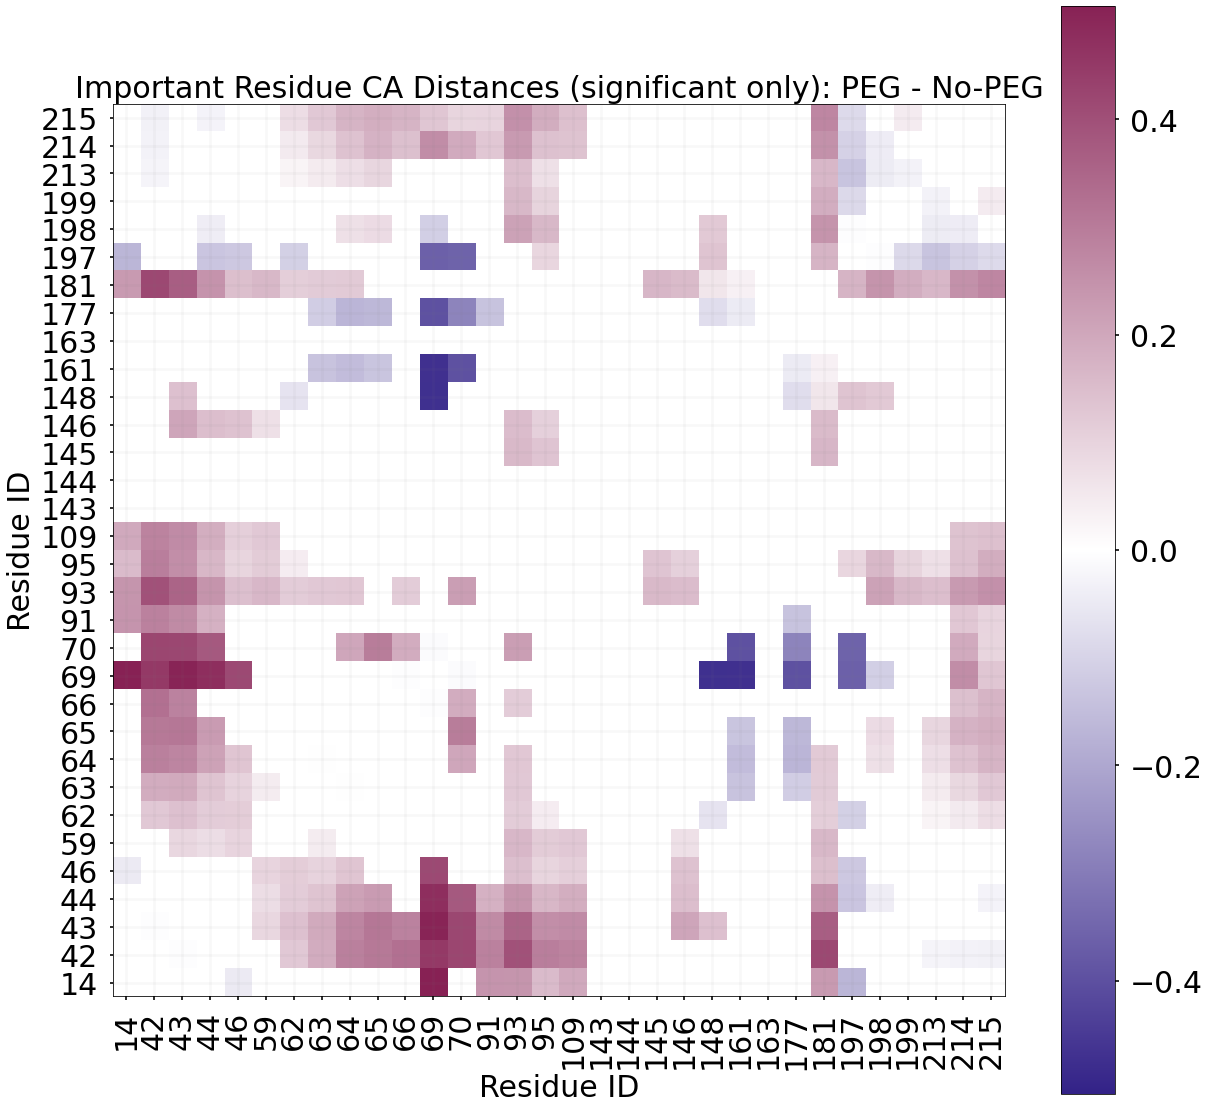

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 1000)
newcolors = viridis(np.linspace(0, 1, 1000))
#This is what you pick
rs = concatenate([linspace(51,256,500),linspace(256,136,500)])/256
gs = concatenate([linspace(34,256,500),linspace(256,34,500)])/256
bs = concatenate([linspace(136,256,500),linspace(256,85,500)])/256
newColours = []
for i in range(len(rs)):
    newColours.append([rs[i],gs[i],bs[i],1])
newcolors = newColours
newcmp = ListedColormap(newcolors)

mean_all_eqdists=[]

for i in range(len(all_dists_timeseries)):
    sub = []
    for j in range(len(all_dists_timeseries[i])):
        mean_eq = mean(all_dists_timeseries[i][j][EQPOINT:],axis = 0)
        
        sub.append(mean_eq)
        
    mean_all_eqdists.append(sub)
    
    
system_importantcadists_avg=[]
system_importantcadists_sem=[]
for i in range(len(mean_all_eqdists)):
    system_importantcadists_avg.append(mean(mean_all_eqdists[i],axis = 0))
    system_importantcadists_sem.append(scipy.stats.sem(mean_all_eqdists[i],axis = 0))

    
diffmap = system_importantcadists_avg[1] - system_importantcadists_avg[0]
semDiffBars = sqrt(system_importantcadists_sem[1]**2 + system_importantcadists_sem[0]**2)


significant_diffbars=copy(diffmap)
for i in range(len(diffmap)):
    for j in range(len(diffmap[i])):

        
        if abs(semDiffBars[i][j]) > abs(diffmap[i][j]):
            significant_diffbars[i][j] = 0
            #semDiffBars[i] = 0
       
    
        
drange = max(abs(significant_diffbars).flatten())

figure(figsize = (20,20))
imshow(significant_diffbars,origin = "lower",cmap=newcmp,vmin=-drange,vmax=drange)#,extent = (resids_proper[0]-0.5,resids_proper[-1]+0.5,resids_proper[0]-0.5,resids_proper[-1]+0.5))

#5.55.55.5
cbar=colorbar()
cbar.ax.tick_params(labelsize=30) 
xlabel("Residue ID",fontsize = 30)
ylabel("Residue ID",fontsize = 30)
title("Important Residue CA Distances (significant only): " +system_names[1] + " - " + system_names[0],fontsize = 30)
dsfasfvdas=xticks(arange(len(importantResids)),importantResids,fontsize = 30,rotation = 90)
asdvfasdvfav=yticks(arange(len(importantResids)),importantResids,fontsize = 30)
  
        
for i in range(len(importantResids)):
    axvline(i,color = "grey",alpha = 0.05)
    axhline(i,color = "grey",alpha = 0.05)

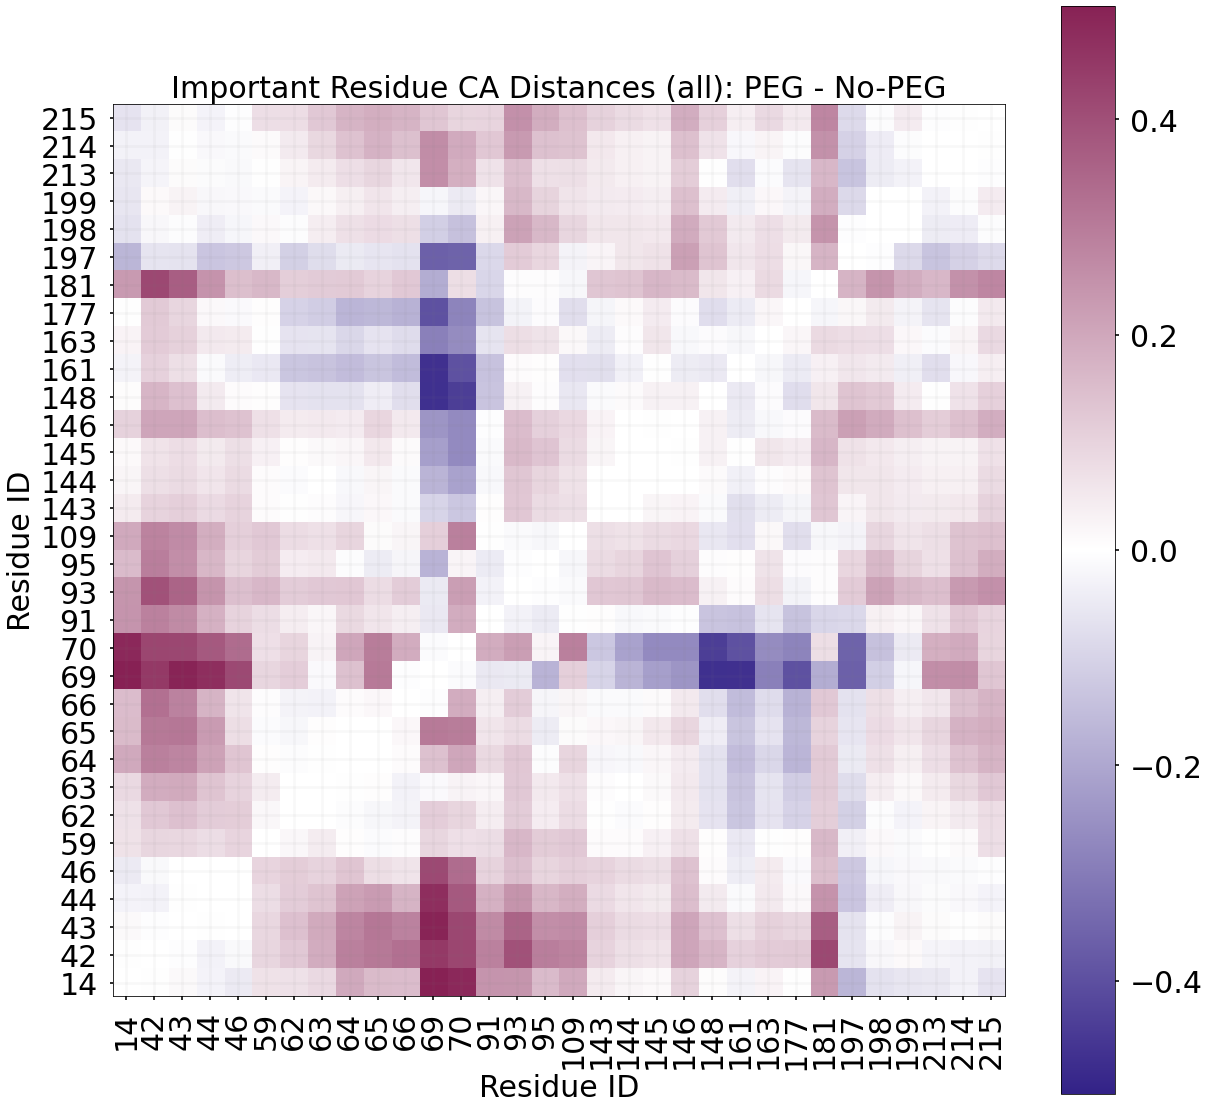

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 1000)
newcolors = viridis(np.linspace(0, 1, 1000))
#This is what you pick
rs = concatenate([linspace(51,256,500),linspace(256,136,500)])/256
gs = concatenate([linspace(34,256,500),linspace(256,34,500)])/256
bs = concatenate([linspace(136,256,500),linspace(256,85,500)])/256
newColours = []
for i in range(len(rs)):
    newColours.append([rs[i],gs[i],bs[i],1])
newcolors = newColours
newcmp = ListedColormap(newcolors)

mean_all_eqdists=[]

for i in range(len(all_dists_timeseries)):
    sub = []
    for j in range(len(all_dists_timeseries[i])):
        mean_eq = mean(all_dists_timeseries[i][j][EQPOINT:],axis = 0)
        
        sub.append(mean_eq)
        
    mean_all_eqdists.append(sub)
    
    
system_importantcadists_avg=[]
system_importantcadists_sem=[]
for i in range(len(mean_all_eqdists)):
    system_importantcadists_avg.append(mean(mean_all_eqdists[i],axis = 0))
    system_importantcadists_sem.append(scipy.stats.sem(mean_all_eqdists[i],axis = 0))

    
diffmap = system_importantcadists_avg[1] - system_importantcadists_avg[0]
semDiffBars = sqrt(system_importantcadists_sem[1]**2 + system_importantcadists_sem[0]**2)
save("ImportantResidueCAPairwiseDistanceDifferenceMap.npy", diffmap)

significant_diffbars=copy(diffmap)
for i in range(len(diffmap)):
    for j in range(len(diffmap[i])):

        
        if abs(semDiffBars[i][j]) > abs(diffmap[i][j]):
            significant_diffbars[i][j] = 0
        
       
    
        
drange = max(abs(significant_diffbars).flatten())

figure(figsize = (20,20))
imshow(significant_diffbars,origin = "lower",cmap=newcmp,vmin=-drange,vmax=drange)#,extent = (resids_proper[0]-0.5,resids_proper[-1]+0.5,resids_proper[0]-0.5,resids_proper[-1]+0.5))

#5.55.55.5
cbar=colorbar()
cbar.ax.tick_params(labelsize=30) 
xlabel("Residue ID",fontsize = 30)
ylabel("Residue ID",fontsize = 30)
title("Important Residue CA Distances (all): " +system_names[1] + " - " + system_names[0],fontsize = 30)
dsfasfvdas=xticks(arange(len(importantResids)),importantResids,fontsize = 30,rotation = 90)
asdvfasdvfav=yticks(arange(len(importantResids)),importantResids,fontsize = 30)
  
        
for i in range(len(importantResids)):
    axvline(i,color = "grey",alpha = 0.05)
    axhline(i,color = "grey",alpha = 0.05)